In [26]:
import sys
import os
if not any(path.endswith('textbook') for path in sys.path):
    sys.path.append(os.path.abspath('../../..'))
from textbook_utils import *

(ch:pandas_aggregating)=
# Aggregating

This section introduces operations for aggregating rows in a dataframe. Data
scientists aggregate rows together to make summaries of data. For instance, a
dataset containing daily sales can be aggregated to show monthly sales instead.
Specifically, we'll introduce *grouping* and *pivoting*, two common operations
for aggregating data.

We'll work with the baby names data, as introduced in the previous section:

In [27]:
baby = pd.read_csv('babynames.csv')
baby

,Name,Sex,Count,Year
0,Liam,M,19659,2020
1,Noah,M,18252,2020
2,Oliver,M,14147,2020
...,...,...,...,...
2020719,Verona,F,5,1880
2020720,Vertie,F,5,1880
2020721,Wilma,F,5,1880


## Basic Group-Aggregate

Let's say we want to find out the total number of babies born as recorded in
this data. This is simply the sum of the `Count` column:

In [28]:
baby['Count'].sum()

352554503

Summing up the name counts is one simple way to aggregate the data---it
combines data from multiple rows.

But let's say we instead want to answer a more interesting question: are U.S.
births trending upwards over time? To answer this question, we can sum the
`Count` column within each year rather than taking the sum over the entire
dataset. In other words, we split the data into groups based on `Year`,
then sum up the `Count` values within each group.
This process is depicted in {ref}`groupby-births`.

```{figure} figures/groupby-births.svg
---
name: groupby-births
alt: groupby-births
---
A depiction of grouping then aggregating for example data.
```

We call this operation **grouping** followed by **aggregating**. In `pandas`,
we write: 

In [29]:
baby.groupby('Year')['Count'].sum()

Year
1880     194419
1881     185772
1882     213385
         ...   
2018    3487193
2019    3437438
2020    3287724
Name: Count, Length: 141, dtype: int64

Notice that the code is nearly the same as the non-grouped version, except that
it starts with a call to `.groupby('Year')`.

The result is a `pd.Series` with the total babies born for each year in the
data. Notice that the index of this series contains the unique `Year` values.
Now we can plot the counts over time:

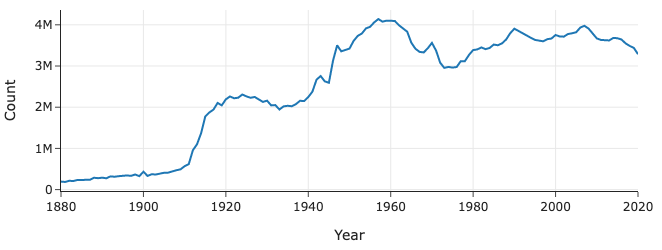

In [30]:
counts_by_year = baby.groupby('Year')['Count'].sum().reset_index()
px.line(counts_by_year, x='Year', y='Count', width=350, height=250)

What do we see in this plot? First, we notice that there seem to be
suspiciously few babies born before 1920. One likely explanation is that the
Social Security Administration was created in 1935, so its data for prior
births could be less complete.

We also notice the dip when World War II began in 1939, and the
post-war Baby Boomer era from 1946-1964.

Here's the basic recipe for grouping in `pandas`:

```python
(baby                # the dataframe
 .groupby('Year')    # column(s) to group
 ['Count']           # column(s) to aggregate
 .sum()              # how to aggregate
)
```

## Grouping on Multiple Columns

We pass multiple columns into `.groupby` as a list to group by multiple
columns at once. This is useful when we need to further subdivide our groups.
For example, we can group by both year and sex to see how many male and female
babies were born over time.

In [31]:
counts_by_year_and_sex = (baby
 .groupby(['Year', 'Sex']) # Arg to groupby is a list of column names
 ['Count']
 .sum()
)
counts_by_year_and_sex 

Year  Sex
1880  F        83929
      M       110490
1881  F        85034
              ...   
2019  M      1785527
2020  F      1581301
      M      1706423
Name: Count, Length: 282, dtype: int64

Notice how the code closely follows the grouping recipe.

The `counts_by_year_and_sex` series has what we call a multi-level index with
two levels, one for each column that was grouped. It's a bit easier to see if
we convert the series to a dataframe:

In [32]:
# The result only has one column
counts_by_year_and_sex.to_frame()

Count
Year Sex         
1880 F      83929
     M     110490
1881 F      85034
...           ...
2019 M    1785527
2020 F    1581301
     M    1706423

[282 rows x 1 columns]

There are two levels to the index because we grouped by two columns. It can be
a bit tricky to work with multilevel indices, so we can reset the index to go
back to a dataframe with a single index.

In [33]:
counts_by_year_and_sex.reset_index()

,Year,Sex,Count
0,1880,F,83929
1,1880,M,110490
2,1881,F,85034
...,...,...,...
279,2019,M,1785527
280,2020,F,1581301
281,2020,M,1706423


## Custom Aggregation Functions

After grouping, `pandas` gives us flexible ways to aggregate the data. So far,
we've seen how to use `.sum()` after grouping:

In [34]:
(baby
 .groupby('Year')
 ['Count']
 .sum() # aggregate by summing
)

Year
1880     194419
1881     185772
1882     213385
         ...   
2018    3487193
2019    3437438
2020    3287724
Name: Count, Length: 141, dtype: int64

`pandas` also supplies other aggregation functions, like `.mean()`, `.size()`,
and `.first()`. Here's the same grouping using `.max()`:

In [35]:
(baby
 .groupby('Year')
 ['Count']
 .max() # aggregate by taking the max within each group
)

Year
1880     9655
1881     8769
1882     9557
        ...  
2018    19924
2019    20555
2020    19659
Name: Count, Length: 141, dtype: int64

But sometimes `pandas` doesn't have the exact aggregation function we want to
use. In these cases, we can define and use a custom aggregation function.
`pandas` lets us do this through `.agg(fn)`, where `fn` is a function that we
define.

For instance, if we want to find the difference between the largest and
smallest values within each group (the range of the data), we could first
define a function called `data_range`, then pass that function into `.agg()`.

In [36]:
# The input to this function is a pd.Series object containing a single column
# of data. It gets called once for each group.
def data_range(counts):
    return counts.max() - counts.min()

(baby
 .groupby('Year')
 ['Count']
 .agg(data_range) # aggregate using custom function
)


Year
1880     9650
1881     8764
1882     9552
        ...  
2018    19919
2019    20550
2020    19654
Name: Count, Length: 141, dtype: int64

## Example: Have People Become More Creative With Baby Names?

Have people become more creative with baby names over time? One way to measure
this is to see whether the number of *unique* baby names per year has increased
over time.

We start by defining a `count_unique` function that counts the number of
unique values in a series. Then, we pass that function into `.agg()`.

In [37]:
def count_unique(s):
    return len(s.unique())

unique_names_by_year = (baby
 .groupby('Year')
 ['Name']
 .agg(count_unique) # aggregate using the custom count_unique function
)
unique_names_by_year

Year
1880     1889
1881     1829
1882     2012
        ...  
2018    29619
2019    29417
2020    28613
Name: Name, Length: 141, dtype: int64

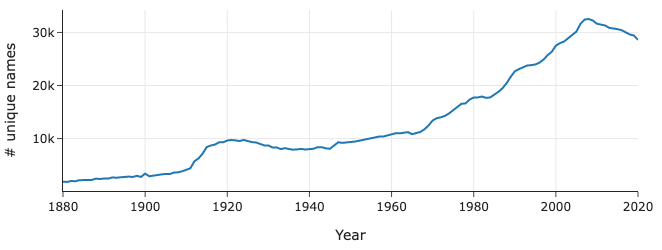

In [38]:
px.line(unique_names_by_year.reset_index(),
        x='Year', y='Name',
        labels={'Name': '# unique names'},
        width=350, height=250)

We see that the number of unique names has generally increased over time, even
though the number of babies born has mostly stabilized since the 1960s.

## Pivoting

Pivoting is essentially a convenient way to arrange the results of a group and
aggregation when grouping with two columns. Earlier in this section we grouped
the baby names data by year and sex:

In [39]:
counts_by_year_and_sex = (baby
 .groupby(['Year', 'Sex']) 
 ['Count']
 .sum()
)
counts_by_year_and_sex.to_frame()

Count
Year Sex         
1880 F      83929
     M     110490
1881 F      85034
...           ...
2019 M    1785527
2020 F    1581301
     M    1706423

[282 rows x 1 columns]

This produces a `pd.Series` with the counts. We can also imagine the same data
with the `Sex` index level "pivoted" to the columns of a dataframe. It's easier
to see with an example:

In [40]:
mf_pivot = pd.pivot_table(
    baby,
    index='Year',   # Column to turn into new index
    columns='Sex',  # Column to turn into new columns
    values='Count', # Column to aggregate for values
    aggfunc=sum)    # Aggregation function
mf_pivot


Sex,F,M
Year,,
1880,83929,110490
1881,85034,100738
1882,99699,113686
...,...,...
2018,1676884,1810309
2019,1651911,1785527
2020,1581301,1706423


Notice that the data values are identical in the pivot table and the table
produced with `.groupby()`; the values are just arranged differently. Pivot
tables are useful for quickly summarizing data using two attributes and are
often seen in articles and papers.

The `px.line()` function also happens to work well with pivot tables,
since the function draws one line for each column of data in the table:

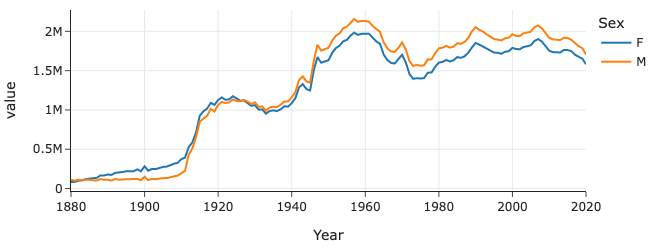

In [45]:
px.line(mf_pivot, width=350, height=250)

## Takeaways

This section covers common ways to aggregate data in `pandas` using
the `.groupby()` function with one or more columns, or by using
the `pd.pivot_table()` function.
In the next section, we'll explain how to join dataframes together.